In [16]:
import pickle, torch, numpy as np, pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data and model
test = pickle.load(open("./windows/test_windows.pkl","rb"))
companies = pickle.load(open("./windows/company_list.pkl","rb"))
ckpt = torch.load("./model.pt", map_location="cpu")

company_to_idx = {c:i for i,c in enumerate(companies)}

class StockTransformer(torch.nn.Module):
    def __init__(self, feature_dim, num_companies):
        super().__init__()
        d_model = 128
        self.input_proj = torch.nn.Linear(feature_dim, d_model)
        self.company_emb = torch.nn.Embedding(num_companies, d_model)
        enc_layer = torch.nn.TransformerEncoderLayer(d_model, 4, batch_first=True)
        self.encoder = torch.nn.TransformerEncoder(enc_layer, 2)
        self.head = torch.nn.Sequential(torch.nn.Linear(d_model,64), torch.nn.ReLU(), torch.nn.Linear(64,1))
    def forward(self, x, c):
        x = self.input_proj(x)
        x = x + self.company_emb(c).unsqueeze(1)
        x = self.encoder(x)
        return self.head(x[:,-1,:]).squeeze(-1)

# Load model
model = StockTransformer(test[0][0].shape[1], len(companies))
model.load_state_dict(ckpt["model_state"])
model.eval()

# Predict
y_true, y_pred, tickers = [], [], []
for X,y,t in test:
    c = torch.tensor([company_to_idx[t]])
    with torch.no_grad():
        p = model(torch.tensor(X).unsqueeze(0), c)
    y_true.append(y); y_pred.append(p.item()); tickers.append(t)

y_true, y_pred = np.array(y_true), np.array(y_pred)
mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]
tickers_clean = np.array(tickers)[mask]

# Row-wise errors
abs_error = np.abs(y_true_clean - y_pred_clean)
percentage_error = abs_error / np.abs(y_true_clean) * 100

# Overall metrics
rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
mae = mean_absolute_error(y_true_clean, y_pred_clean)
r2 = r2_score(y_true_clean, y_pred_clean)
direction_acc = np.mean(np.sign(np.diff(y_true_clean)) == np.sign(np.diff(y_pred_clean)))

print(f"✅ RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, DirectionAcc={direction_acc*100:.2f}%")

# Save predictions + row-wise errors
df = pd.DataFrame({
    "Company": tickers_clean,
    "Actual": y_true_clean,
    "Predicted": y_pred_clean,
    "Abs_Error": abs_error,
    "Percentage_Error": percentage_error
})

# Save overall metrics in the first row or as a separate row
df.loc['Overall_Metrics'] = ["Metrics", "", "", rmse, mae]  # Optionally add more metrics

df.to_csv("predictions_test_with_row_errors.csv", index=False)
print("Saved predictions_test_with_row_errors.csv with row-wise errors")

/tmp/ipykernel_72262/1032129696.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./model.pt", map_location="cpu")


✅ RMSE=111.6415, MAE=87.0852, R²=-0.4214, DirectionAcc=49.23%
Saved predictions_test_with_row_errors.csv with row-wise errors


Defaulting to user installation because normal site-packages is not writeable
Top 10 Absolute Errors:
     Company      Actual   Predicted   Abs_Error  Percentage_Error
1534    MSFT  453.549988   83.738388  369.811600         81.537120
1619    MSFT  454.459991   84.846855  369.613136         81.330182
1286    MSFT  466.239990  101.023247  365.216743         78.332351
930     MSFT  446.339996   88.391907  357.948090         80.196284
551     MSFT  441.579987   86.987404  354.592583         80.300873
656     MSFT  437.390015   85.483299  351.906715         80.456047
509     MSFT  430.809998   82.762367  348.047630         80.789126
1475    MSFT  452.850006  110.060699  342.789307         75.695992
375     MSFT  431.200012   90.956825  340.243187         78.906117
631     MSFT  424.570007   84.503746  340.066261         80.096628

Top 10 Percentage Errors:
     Company    Actual   Predicted   Abs_Error  Percentage_Error
545     NVDA  12.80475  130.833725  118.028975        921.759273
828 

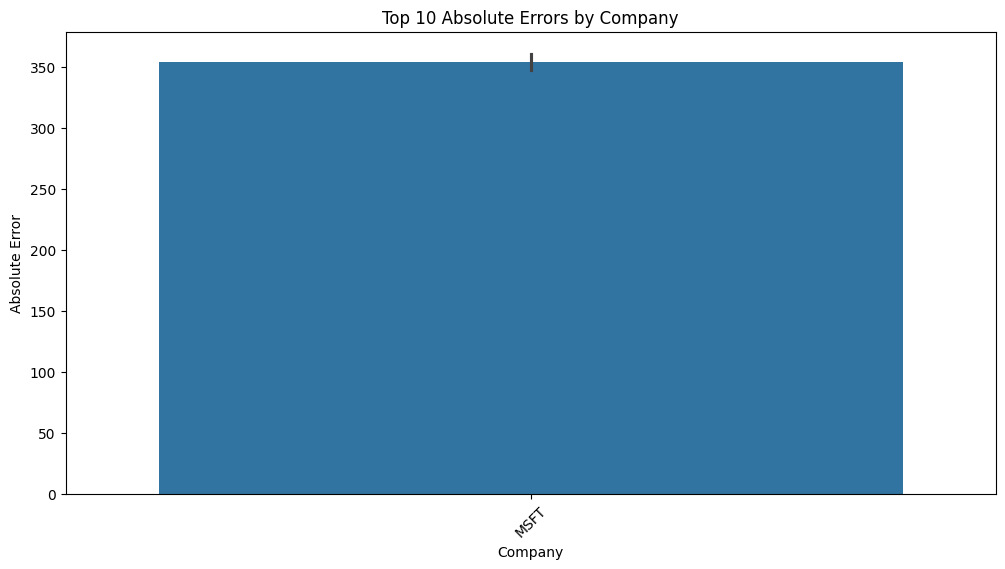

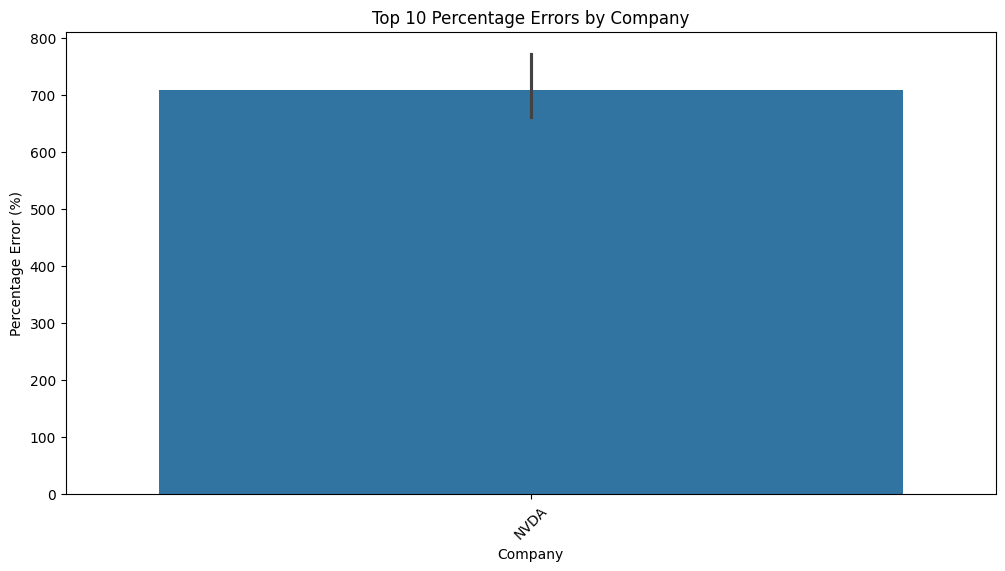

In [ ]:
# !pip install pandas matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV with row-wise errors
df = pd.read_csv("predictions_test_with_row_errors.csv")

# If your CSV has "Metrics" row at the end, remove it for plotting
df = df[df['Company'] != 'Metrics']

# Convert columns to numeric if necessary
df['Abs_Error'] = pd.to_numeric(df['Abs_Error'], errors='coerce')
df['Percentage_Error'] = pd.to_numeric(df['Percentage_Error'], errors='coerce')

# Top 10 largest absolute errors
top_abs = df.sort_values(by='Abs_Error', ascending=False).head(10)
print("Top 10 Absolute Errors:")
print(top_abs[['Company','Actual','Predicted','Abs_Error','Percentage_Error']])

# Top 10 largest percentage errors
top_pct = df.sort_values(by='Percentage_Error', ascending=False).head(10)
print("\nTop 10 Percentage Errors:")
print(top_pct[['Company','Actual','Predicted','Abs_Error','Percentage_Error']])

# Plot absolute errors
plt.figure(figsize=(12,6))
sns.barplot(x='Company', y='Abs_Error', data=top_abs)
plt.title("Top 10 Absolute Errors by Company")
plt.xticks(rotation=45)
plt.ylabel("Absolute Error")
plt.show()

# Plot percentage errors
plt.figure(figsize=(12,6))
sns.barplot(x='Company', y='Percentage_Error', data=top_pct)
plt.title("Top 10 Percentage Errors by Company")
plt.xticks(rotation=45)
plt.ylabel("Percentage Error (%)")
plt.show()
